## Gerekli kütüphaneler:
Modelin kurulumu ve eğitim süreci için gerekli tüm paketleri içe aktarılır.

In [ ]:
import sys

sys.path.append("../..")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from utils.cnn.preprocessing import get_data_generators
from utils.utils import plot_training_history

## Konfigürasyonlar:
Model eğitimi için kullanılan temel parametreler tanımlanır.

In [2]:
data_directory = "../../data/skyview"
image_size = (256, 256)
batch_size = 16
epochs = 30
number_of_classes = 15 # skyview için 15

## Veriyi yükleme ve ön işleme:
`utils/preprocessing.py` içindeki `get_data_generators` fonksiyonu kullanılarak
eğitim ve doğrulama veri kümeleri hazırlanır.

In [3]:
print("Veri yükleniyor.")
train_gen, val_gen = get_data_generators(data_directory, image_size, batch_size)

print("Sınıf indeksleri:", train_gen.class_indices)
print("Eğitim örnekleri:", train_gen.samples)
print("Doğrulama örnekleri:", val_gen.samples)

Veri yükleniyor.
Found 10200 images belonging to 15 classes.
Found 1800 images belonging to 15 classes.
Sınıf indeksleri: {'Agriculture': 0, 'Airport': 1, 'Beach': 2, 'City': 3, 'Desert': 4, 'Forest': 5, 'Grassland': 6, 'Highway': 7, 'Lake': 8, 'Mountain': 9, 'Parking': 10, 'Port': 11, 'Railway': 12, 'Residential': 13, 'River': 14}
Eğitim örnekleri: 10200
Doğrulama örnekleri: 1800


## Modelin mimarisi:
Uydu görüntülerini sınıflandırmak üzere tasarlanmış bir Convolutional Neural Network (CNN) modeli oluşturulur.

In [4]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),

    Conv2D(48, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(96, activation="relu"),
    Dropout(0.4),
    Dense(number_of_classes, activation="softmax")
])

optimizer = Adam(learning_rate=0.0005)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

steps_per_epoch = train_gen.samples // batch_size
validation_steps = val_gen.samples // batch_size

print("Epoch başına adım:", steps_per_epoch)
print("Doğrulama adımları:", validation_steps)

c:\Users\mehmet\Desktop\LandCoverClassifier\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 48)   │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │     5,529,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,573,631 (21.26 MB)

 Trainable params: 5,573,631 (21.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch başına adım: 637
Doğrulama adımları: 112


## Modelin eğitimi:
Model eğitimi başlatılır ve eğitim süreci boyunca callback mekanizmaları burada kullanılır.

In [5]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

print("Model eğitimi başladı.")
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=[early_stop]
)

print("Model eğitimi tamamlandı.")

Model eğitimi başladı.


c:\Users\mehmet\Desktop\LandCoverClassifier\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
  9/638 ━━━━━━━━━━━━━━━━━━━━ 7:21 703ms/step - accuracy: 0.0523 - loss: 2.7800

KeyboardInterrupt: 

## Sonuçları görselleştirme:
Eğitim sürecinde modelin doğruluk değerlerinin nasıl değiştiğini grafik olarak gösterilir. Eğitim ve doğrulama doğruluğu birlikte çizilerek modelin öğrenme eğrisi takip edilir.

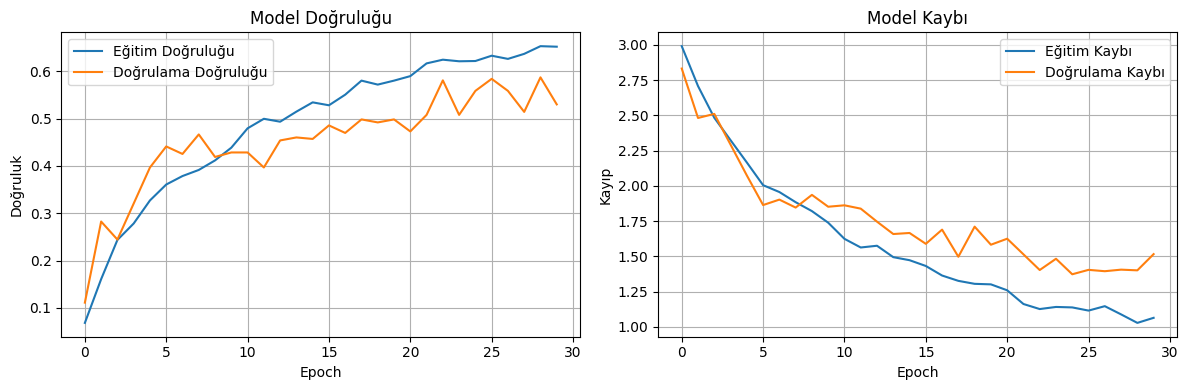

In [ ]:
plot_training_history(history)

## Modeli kaydetme:
Eğitim tamamlandıktan sonra model `.keras` formatında kaydedilir. Bu sayede daha sonra test etmek veya tekrar yüklemek üzere kullanılabilir.

In [ ]:
model.save("../../models/cnn/model_skyview.keras")